<a href="https://colab.research.google.com/github/TheDodoDev/PyTorch-Notes/blob/main/01_PyTorch_Workflow_Notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Workflow

Let's explore an example PyTorch end-to-end workflow.

Resources:
* Ground truth notebook - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/01_pytorch_workflow.ipynb
* Book version of notebook - https://www.learnpytorch.io/01_pytorch_workflow/

In [144]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt
import numpy as np

#Check PyTorch version
torch.__version__

'2.6.0+cu124'

## 1. Preparing and loading data

Data can be almost anything in machine learning.
* Excel spreadsheet
* Images of any kind
* Videos (YouTube has lots of data...)
* Audio like songs or podcasts
* DNA
* Text

ML is a game of 2 parts:
1. Get data into a numerical representation
2. Build a model to learn patterns in that numerical representation

To showcase this, let's create some *known* data using the linear regression formula to make a straight line with *known* **parameters**.

In [145]:
# Create known parameters
weight = 0.7
bias = 0.3

# Create some data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10], len(X), len(y), X.shape

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50,
 torch.Size([50, 1]))

### Splitting data into training and test sets

Let's create a training and test set with our data.

In [146]:
# Create a train/test split
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualize our data?
This is where the data explorer's motto comes in!

`"Visualize, visualize, visualize!"`

In [147]:
def plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=None):
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  #Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  #Show the legend
  plt.legend(prop={"size": 14});

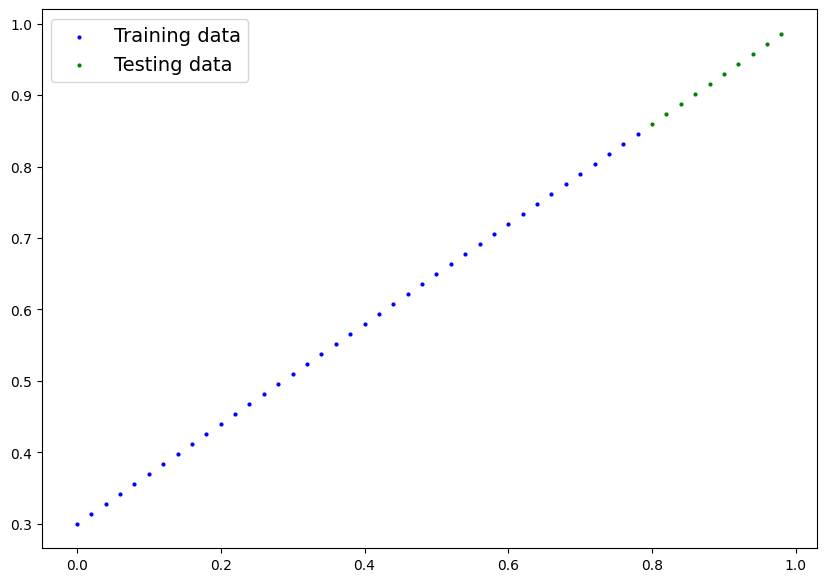

In [148]:
plot_predictions()

## 2. Build model

What our model does:
* Start with random values (weight & bias)
* Look at training data and adjust random values to get closer to ideal values

It does this through 2 main algorithms:
1. Gradient descent (`requires_grad = True`)
2. Backpropagation

In [149]:
# Create a linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inherits from nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))

  # Forward Method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # "x" is the input data
    return self.weights * x + self.bias # this is the linear regression formula

### PyTorch model building essentials

* **torch.nn** - contains all of the building blocks for computational graphs (neural networks are considered computational graphs)
* **torch.nn.Parameter** - what parameters should our model try and learn, often a PyTorch layer from which torch.nn will set these for us
* **torch.nn.Module** - The base class for all neural network module, if you subclass it, you should overwrite `forward()`
* **torch.optim** - this is where the optimizers in PyTorch live, help with gradient descent
* **def forward()** - all nn.Module subclasses require this method to be overwritten, defines what happens in the forward computation
*  **torch.utils.data.Dataset** - represents a map between key (label) and sample (features) pairs of your data such as images and their associated labels
* **torch.utils.data.DataLoader** - creates a Python iterable over a torch Dataset (allows you to iterate over your data)

### Checking the contents of our PyTorch model

In [150]:
# Create a random seed
torch.manual_seed(42)

#Create an instance of the model (a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check model parameters using .parameters()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [151]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()`

To check our model's predictive power, let's see how well it predicts `y_test` based on `X_test`

When we pass data through our model, it is going to run it through the `forward()` method.

In [152]:
# Makes predictions with model

with torch.inference_mode(): # <- Turns off gradient tracking and uses less data/memory when making predictions
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [153]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

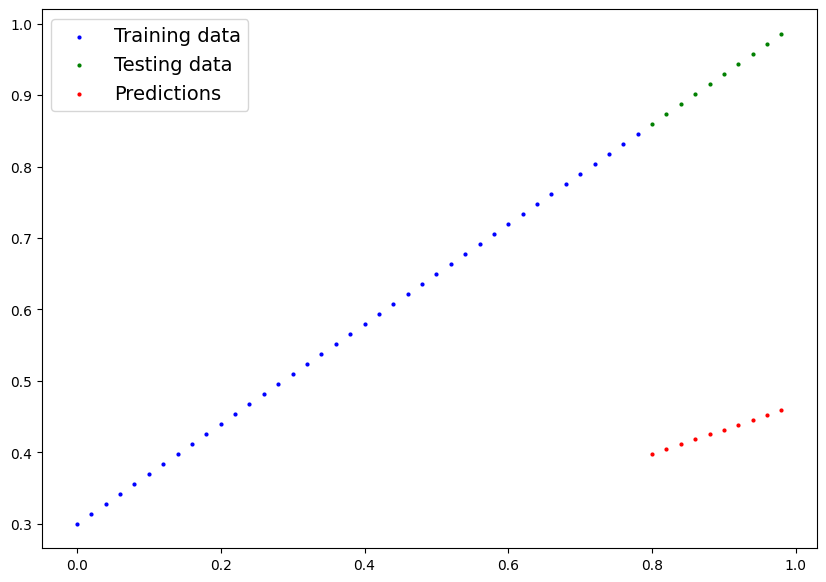

In [154]:
plot_predictions(predictions=y_preds) # Prediction is off because the initial parameters are random and haven't been changed to try to fit the data

## 3. Train model

The purpose of training is for a model to move from unknown parameters to some *known* parameters (from poor representation to better representation of data).

Things needed to train a model:

* **Loss function:** A function that measures how off a model's predictions are to expected output
 * *Note:* Loss function may also be called cost function or criterion in different areas
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (e.g. weight and bias) to improve loss function
* PyTorch specifically also requires a *training loop* and a *testing loop*

  

In [155]:
# Check contents of our model
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

**Learning rate** - higher the rate, the more it changes the parameters

In [156]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.001) # lr = learning rate = possibly the most important hyperparameter you can set

### Building a training loop in PyTorch

There are a couple of things we need in a training loop:
0. Loop through the data
1. Forward pass - this involves data moving through model's `forward()` function aka forward propogation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each parameter of our model with respect to our loss (**backpropogation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [157]:
# An epoch is one loop through the data
epochs = 2000

# Store values in an array
epoch_count = []
loss_values = []
test_loss_values = []

# 0. Loop through the data
for epoch in range(epochs + 1):
  # Set the model to training mode that sets all parameters that require gradients to require gradients
  model_0.train()

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimize zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on loss with respect to model parameters
  loss.backward()

  # 5. Step the optimizer
  optimizer.step() # by default, how the optimizer changes accumlates through the loop -> as a result, gradients need to be reset to prevent excess change

  ### Testing
  model_0.eval() # turns off gradient tracking in testing mode (dropout/batch norm layers)
  with torch.inference_mode():
    # 1. Do the forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    if(epoch % 100 == 0):
      print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
      print(model_0.state_dict())


Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.4931890368461609
OrderedDict([('weights', tensor([0.3371])), ('bias', tensor([0.1298]))])
Epoch: 100 | Loss: 0.19767141342163086 | Test loss: 0.35847947001457214
OrderedDict([('weights', tensor([0.3761])), ('bias', tensor([0.2298]))])
Epoch: 200 | Loss: 0.08973254263401031 | Test loss: 0.22795839607715607
OrderedDict([('weights', tensor([0.4150])), ('bias', tensor([0.3257]))])
Epoch: 300 | Loss: 0.05357731133699417 | Test loss: 0.15086300671100616
OrderedDict([('weights', tensor([0.4485])), ('bias', tensor([0.3730]))])
Epoch: 400 | Loss: 0.04549176245927811 | Test loss: 0.11657620966434479
OrderedDict([('weights', tensor([0.4730])), ('bias', tensor([0.3855]))])
Epoch: 500 | Loss: 0.04160415381193161 | Test loss: 0.10088418424129486
OrderedDict([('weights', tensor([0.4924])), ('bias', tensor([0.3839]))])
Epoch: 600 | Loss: 0.03811401128768921 | Test loss: 0.08986451476812363
OrderedDict([('weights', tensor([0.5104])), ('bias', tensor([

In [158]:
loss, model_0.state_dict()

(tensor(0.0004, grad_fn=<MeanBackward0>),
 OrderedDict([('weights', tensor([0.6997])), ('bias', tensor([0.3008]))]))

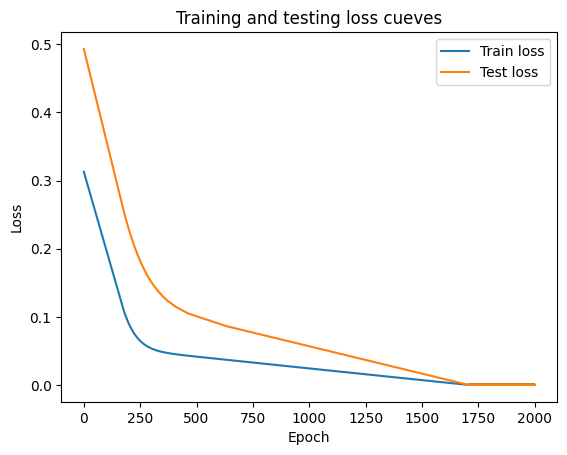

In [159]:
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).numpy()), label="Test loss")
plt.title("Training and testing loss cueves")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()